In [1]:
import torch
from torchvision import models
from datasets import *
from tqdm import tqdm
import imageio
import urllib.request
import cv2
import os
from PIL import Image

In [2]:
teacher = models.efficientnet_b0(weights='DEFAULT').to('cuda').eval()
student = models.shufflenet_v2_x0_5(weights='DEFAULT').to('cuda').eval()

In [3]:
test_tf = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ConvertImageDtype(torch.float),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

val_loader = load_imagenet(64,1234,False)
def get_label(idx):
    return val_loader.dataset.class_name_map[val_loader.dataset.class_id_list[idx]]

In [4]:
def save_gif(url,fname):
    os.mkdir(fname.split(".")[0])

    ## Read the gif from the web, save to the disk
    imdata = urllib.request.urlopen(url).read()
    imbytes = bytearray(imdata)
    open(fname,"wb+").write(imdata)

    ## Read the gif from disk to `RGB`s using `imageio.miread` 
    gif = imageio.mimread(fname)
    print("Total {} frames in the gif!".format(len(gif)))

    for i,img in enumerate(gif):
        cv2.imwrite(fname.split(".")[0]+"/"+str(i)+".png", cv2.cvtColor(img[:,:,:3],cv2.COLOR_BGR2RGB))

In [20]:
def inf_gif(url,fname,model):

    ## Read the gif from the web, save to the disk
    imdata = urllib.request.urlopen(url).read()
    imbytes = bytearray(imdata)
    open(fname,"wb+").write(imdata)

    ## Read the gif from disk to `RGB`s using `imageio.miread` 
    gif = imageio.mimread(fname)
    print("Total {} frames in the gif!".format(len(gif)))

    preds = torch.zeros(len(gif))
    with torch.no_grad():
        for i,img in enumerate(gif):
            frame = cv2.cvtColor(np.array(img[:,:,:3]),cv2.COLOR_BGR2RGB)
            frame = transforms.ToTensor()(frame).to('cuda')
            preds[i] = model(test_tf(frame).unsqueeze(0)).argmax()

    return preds

In [29]:
c = "ice bear"
c = "fire engine"
paths = {'ice bear':"https://i.gifer.com/67Kr.gif",'fire engine':"https://media.tenor.com/BqedYho27HAAAAAC/station19-fire-truck.gif"}

preds_s = inf_gif(paths[c],"test.gif",student)
preds_t = inf_gif(paths[c],"test.gif",teacher)

s_count = 0
t_count = 0
for pred in preds_s:
    if get_label(int(pred))[1:] == c:
        s_count += 1
for pred in preds_t:
    if get_label(int(pred))[1:] == c:
        t_count += 1
print(f"s: {s_count/len(preds_s)}, t: {t_count/len(preds_t)}")

Total 35 frames in the gif!
Total 35 frames in the gif!
s: 0.0, t: 0.0


In [36]:
import pandas as pd

dfs = []
for percent in [0,25,50,75,100]:
    # open the text file and read the lines into a list
    with open(str(percent)+'.txt', 'r') as f:
        lines = f.readlines()

    # create an empty list to hold the dictionaries
    data = []

    # loop over the lines and extract the key-value pairs
    for line in lines:
        parts = line.strip().split(', ')
        d = {}
        for part in parts:
            key, value = part.split(':')
            d[key] = value
        data.append(d)

    # convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(data)

    # convert the columns to their appropriate types (float, int, etc.)
    df = df.astype({'i': int, 'm': str, 'fps': float, 'rand': float, 'p': float, 'time': float})
    dfs.append(df)


Text(0, 0.5, 'FPS')

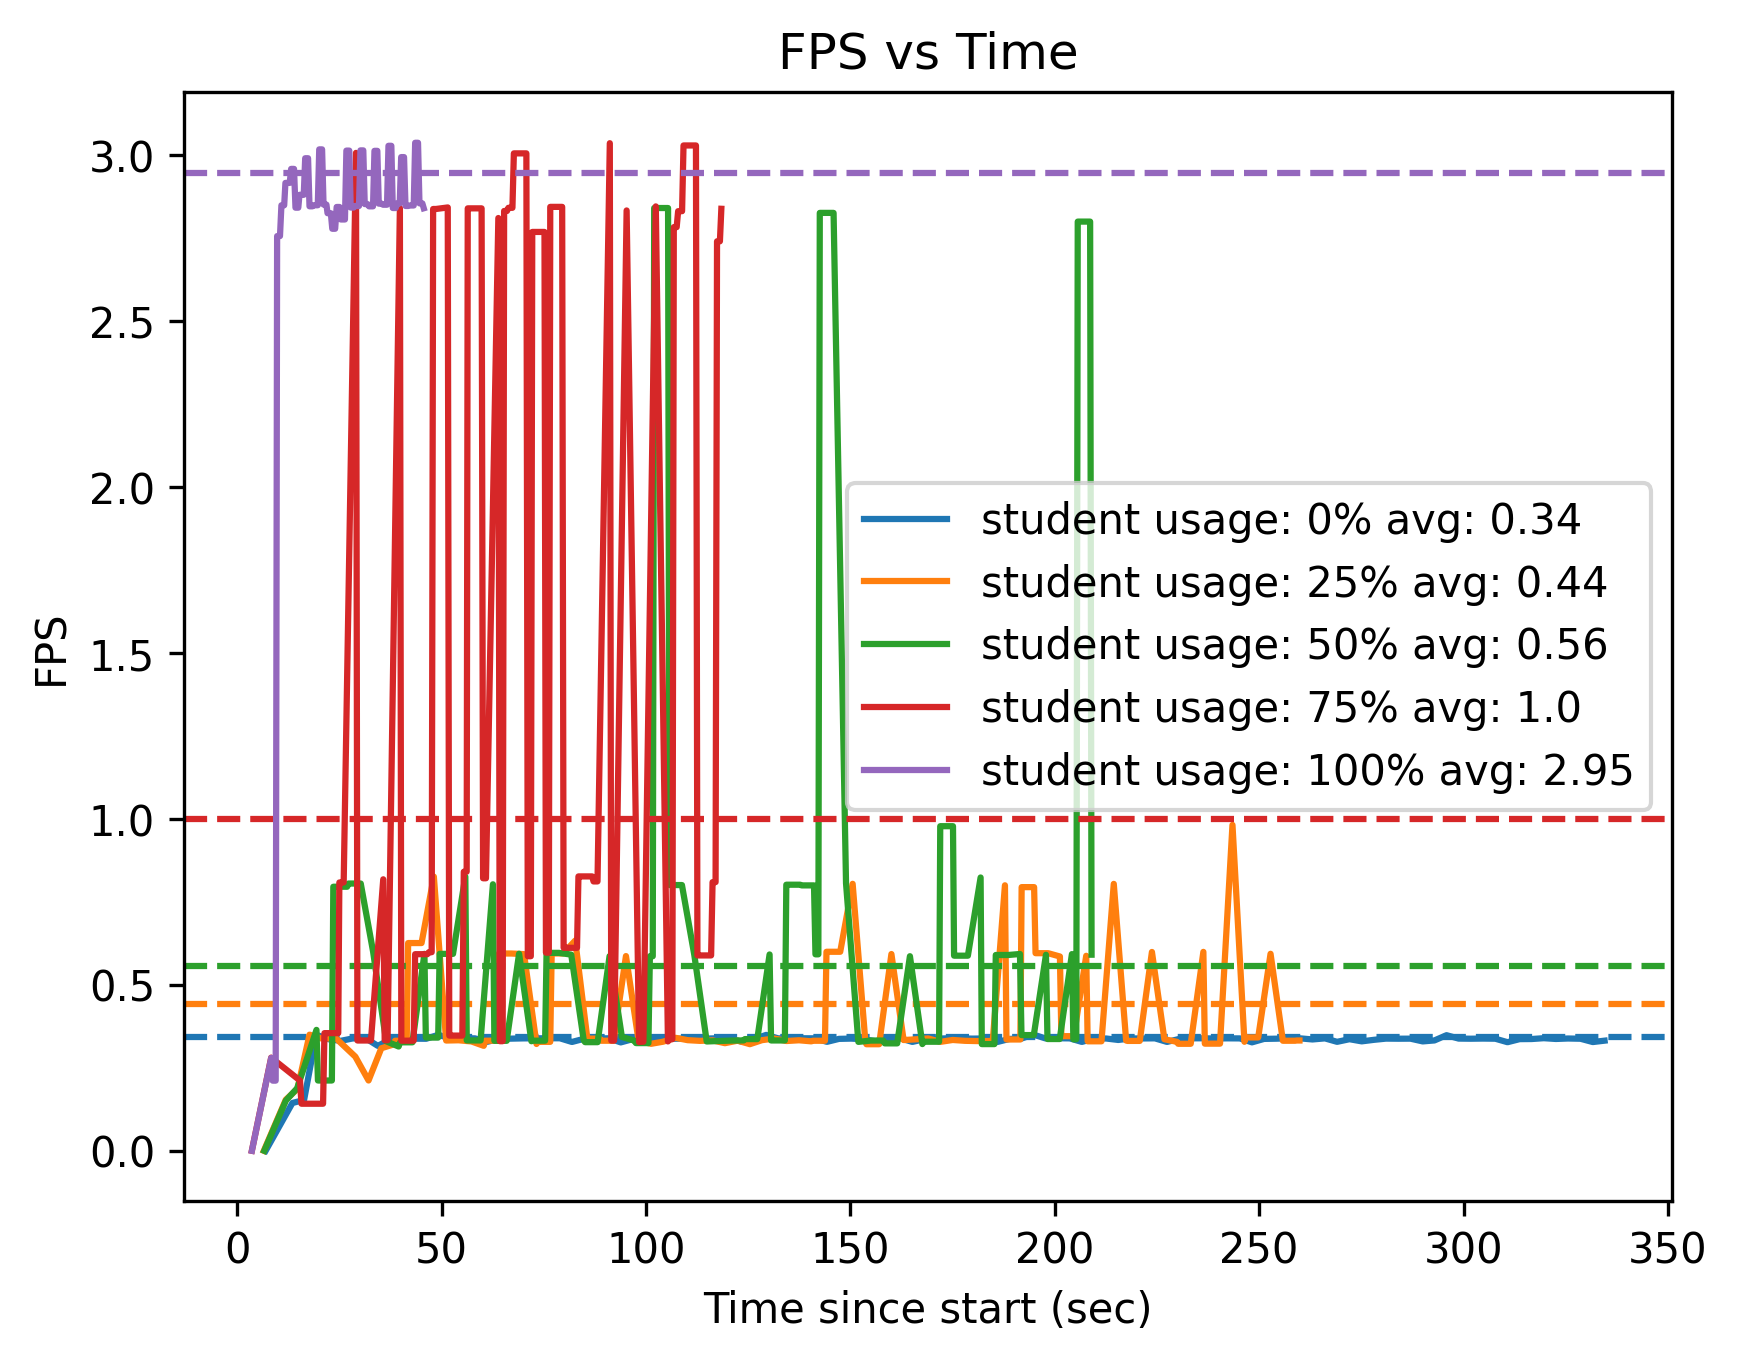

In [64]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
p = [0,25,50,75,100]
for i,df in enumerate(dfs):
    y = df['fps'].values
    x = df['time'].values
    plt.plot(x,y,label="student usage: "+str(p[i])+"% avg: "+str(round(110/(x[-1]-x[1]),2)) ,c=cycle[i])
    plt.axhline(110/(x[-1]-x[1]),c=cycle[i],linestyle="--")
plt.legend() 
plt.title("FPS vs Time")
plt.xlabel("Time since start (sec)")
plt.ylabel("FPS")

# Prediction Confidence Over Time

In [33]:
model = models.resnet50(weights='DEFAULT').to('cuda').eval()

In [4]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

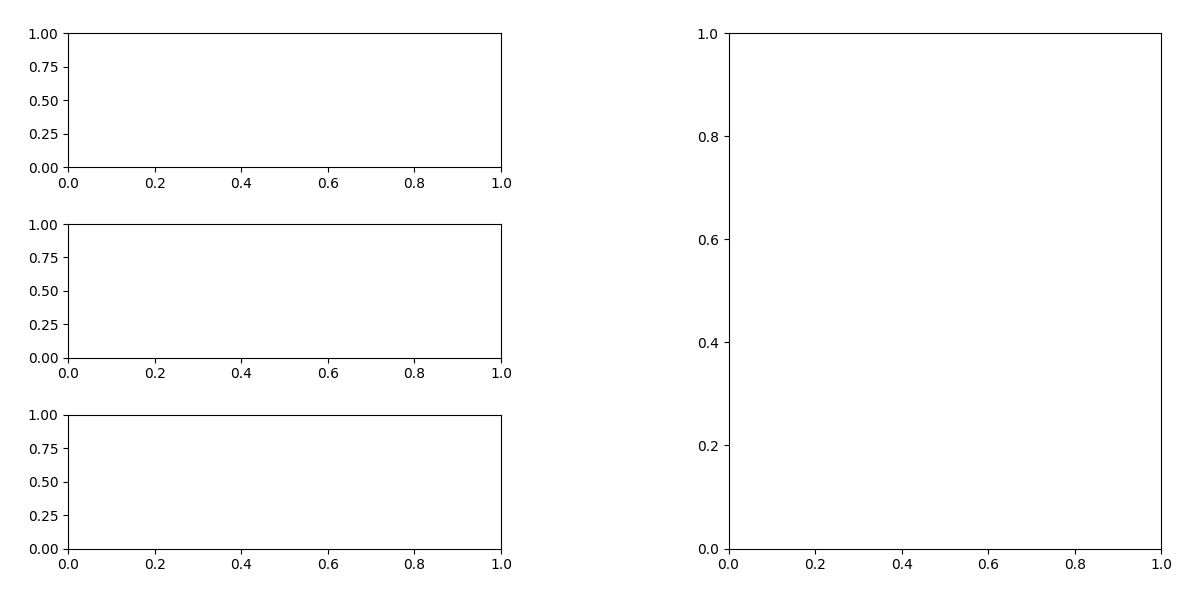

In [77]:
root_dir = "../data/imagenet_vid_ytbb_robust/imagenet-vid-robust/val/"
vid_dirs = os.listdir(root_dir)

preds = []
dir_idx = 3
track_dict_student = {}
track_dict_teacher = {}
track_dict_teacher_big = {}
track_dicts = [track_dict_student, track_dict_teacher, track_dict_teacher_big]
models = [student,teacher,model]

img_list = sorted(os.listdir(os.path.join(root_dir,vid_dirs[dir_idx])))

images = []
max_confs = [0,0,0]
for i,img in enumerate(img_list):
    image = Image.open(os.path.join(root_dir,vid_dirs[dir_idx],img))
    images.append(image)
    for id,track_dict in enumerate(track_dicts):
        # get a prediction for the current frame
        with torch.no_grad():
            frame = transforms.ToTensor()(image).to('cuda')
            pred = models[id](test_tf(frame).unsqueeze(0)).cpu().view(-1)
        # get the top five for the first frame
        if i == 0:
            vals,idxs = torch.topk(pred,5)
            for j,idx in enumerate(idxs):
                track_dict[idx.item()] = np.zeros(len(img_list))
                track_dict[idx.item()][i] = vals[j]
                if vals[j] > max_confs[id]:
                    max_confs[id] = vals[j]
        # track confidences for these over time
        else:
            for j,idx in enumerate(track_dict.keys()):
                track_dict[idx][i] = pred[idx]
                if pred[idx] > max_confs[id]:
                    max_confs[id] = pred[idx]

plt.close()
fig,ax = plt.subplot_mosaic([['shufflenet_v2_x0_5','space','image'],
                              ['efficientnet_b0','space','image'],
                              ['resnet_50','space','image'],],figsize=(12,6),
                              gridspec_kw={'width_ratios':[0.5,0.1,0.5],
                                           'height_ratios': [1,1,1]})
fig.tight_layout(pad=2.0)
ax['space'].axis('off')
names = ["shufflenet_v2_x0_5","efficientnet_b0","resnet_50"]

def animate(i):
    ax['image'].clear()
    id = 0
    for name,track_dict in zip(names,track_dicts):
        ax[name].clear()
        
        for k in track_dict.keys():
            ax[name].plot(np.arange(i+1),track_dict[k][:i+1],label=get_label(k))
            ax[name].set_xticks(np.arange(len(track_dict[k])))
        ax[name].set_xlim([0,len(img_list)])
        ax[name].grid()
        ax[name].set_ylim([0,max_confs[id]+1])
        ax[name].set_title(name)
        ax[name].set_ylabel('confidence (%)')
        if id == len(names)-1:
            ax[name].set_xlabel('frame #')
        ax[name].legend(bbox_to_anchor=(1.45, 1))
        id += 1
    ax['image'].imshow(images[i])
    

# run the animation
ani = FuncAnimation(fig, animate, frames=len(images), interval=300, repeat=False)

plt.show()